# ChatGPT Movie recommendation engine
This notebook contains the implementation of a movie recommendation system using the OpenAI framework, check the paper and official project page by Wei Wei, Xubin Ren, Jiabin Tang, Qinyong Wang, Lixin Su, Suqi Cheng, junfeng wang, Dawei Yin, Chao Huang at https://llmrec.github.io/.

## Architecture

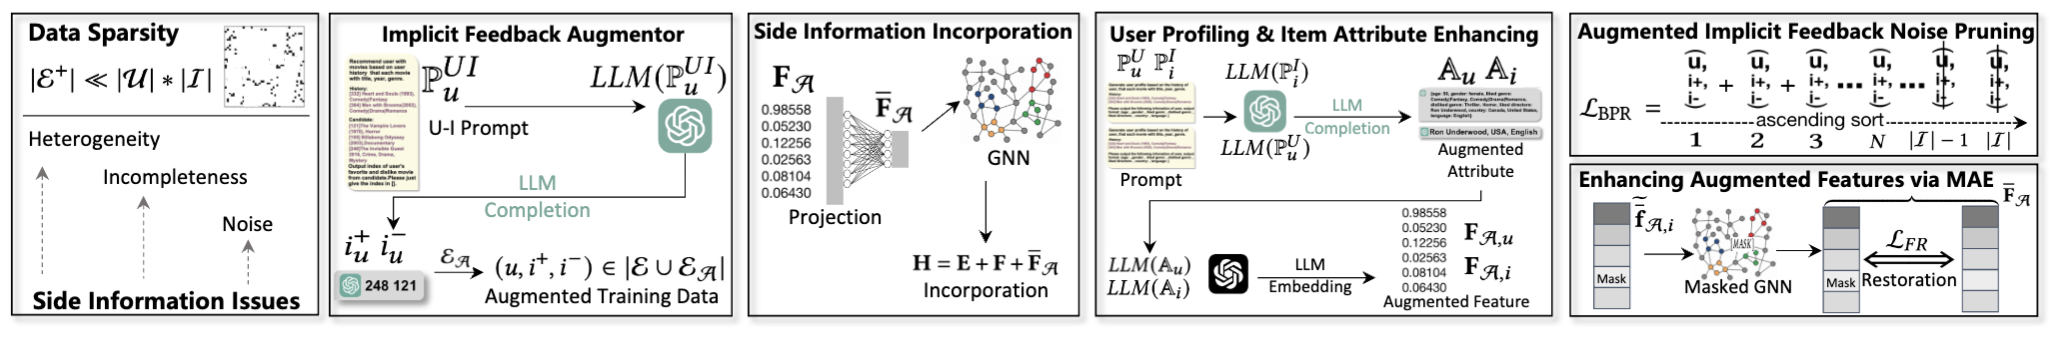

In [1]:
from IPython.display import Image
Image("framework.png")

## Imports and Environment Setup
This section imports necessary libraries and sets up the environment for the recommendation system. It includes basic Python libraries, PyTorch for deep learning functionalities, and other utility libraries.

In [ ]:
from datetime import datetime
import math
import os
import random
import sys
from time import time
from tqdm import tqdm
import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.sparse as sparse
from torch import autograd
import random

import copy

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from utility.parser import parse_args
from Models import MM_Model, Decoder  
from utility.batch_test import *
from utility.logging import Logger
from utility.norm import build_sim, build_knn_normalized_graph

import setproctitle

args = parse_args()

## LLM augmentation construct prompt
Make a carefully crafted input statement to leverage the capabilities of the LLM more effectively for recommending the movies. 

### Attribute generation
A large Language Model (LLM), i.e. GPT-4 is used to generate or identify attributes, characteristics, or features of a given subject, concept, or entity. This process involves the LLM analyzing the input, understanding the context, and then producing relevant attributes for the movie recommender.

In [ ]:
import threading
import openai
import time
import pandas as pd
import pickle
import os
import numpy as np
import torch

# openai.api_key = ""
openai.api_key = ""

import requests

file_path = ""

### Netflix
As an example, consider only movies on Netflix for our recommender.

In [ ]:
def construct_prompting(item_attribute, indices): 
     # pre string
     pre_string = "You are now a search engine required to provide the inquired information of the given movies bellow:\n"

Now, create the list of these items.

In [ ]:
item_list_string = ""
for index in indices:         
    title = item_attribute['title'][index]
    item_list_string += "["
    item_list_string += str(index)
    item_list_string += "] "
    item_list_string += str(year) + ", "
    item_list_string += title + ", "

Choosing a right output format is important for further steps.

In [ ]:
output_format = "The inquired information is : director, country, language.\nAnd please output them in form of: \ndirector::country::language\nplease output only the content in the form above, i.e., director::country::language\n, but no other things, no reasoning, no index.\n\n"

The next step is constructing the prompt.

In [ ]:
prompt = pre_string + item_list_string + output_format 
return prompt 

## ChatGPT attribute generation
ChatGPT, as a specific type of Large Language Model (LLM) developed by OpenAI, generates attributes, characteristics, or features of a given subject, concept, or entity in response to a user's query. This involves the AI analyzing the input, understanding the context, and producing relevant attributes based on its extensive training data and the information provided in the prompt.

In [ ]:
def LLM_request(toy_item_attribute, indices, model_type, augmented_attribute_dict, error_cnt):
    if indices[0] in augmented_attribute_dict:
        return 0
    else:
        try: 
            print(f"{indices}")
            prompt = construct_prompting(toy_item_attribute, indices)
            url = "https://api.openai.com/v1/completions"
            headers={
                # "Content-Type": "application/json",
                "Authorization": "Bearer your key"
            }



The function LLM_request is defined with several parameters: toy_item_attribute, indices, model_type, augmented_attribute_dict, and error_cnt. These parameters suggest that the function is intended to handle requests related to toy items and their attributes.

In [ ]:
 params={
                "model": "text-davinci-003",
                "prompt": prompt,
                "max_tokens": 1024,
                "temperature": 0.6,
                "stream": False,
            } 

'requests.post' is a function from the requests library in Python, used to make an HTTP POST request to a specified URL.

In [ ]:
response = requests.post(url=url, headers=headers,json=params)
            message = response.json()

The variable 'message' holds the response from the API call, parsed as a Python dictionary.

In [ ]:
content = message['choices'][0]['text']
            print(f"content: {content}, model_type: {model_type}")

Next, we process text content, returned from the OpenAI API, and then store it in a dictionary by pickling the dictionary for persistent storage.

In [ ]:
rows = content.strip().split("\n")  # Split the content into rows
            for i,row in enumerate(rows):
                elements = row.split("::")  # Split each row into elements using "::" as the delimiter
                director = elements[0]
                country = elements[1]
                language = elements[2]
                augmented_attribute_dict[indices[i]] = {}
                augmented_attribute_dict[indices[i]][0] = director
                augmented_attribute_dict[indices[i]][1] = country
                augmented_attribute_dict[indices[i]][2] = language
            # pickle.dump(augmented_sample_dict, open('augmented_sample_dict','wb'))
            pickle.dump(augmented_attribute_dict, open(file_path + 'augmented_attribute_dict','wb'))
  

Finally, let's handle all the exceptions:

In [ ]:
 except requests.exceptions.RequestException as e:
            print("An HTTP error occurred:", str(e))
            # time.sleep(25)
            # print(content)
            error_cnt += 1
            if error_cnt==5:
                return 1
            LLM_request(toy_item_attribute, indices, "gpt-3.5-turbo-0613", augmented_attribute_dict, error_cnt)

In [ ]:
 except ValueError as ve:
            print("ValueError error occurred while parsing the response:", str(ve))
            # time.sleep(25)
            error_cnt += 1
            if error_cnt==5:
                return 1
            # print(content)
            LLM_request(toy_item_attribute, indices, "gpt-3.5-turbo-0613", augmented_attribute_dict, error_cnt)


In [ ]:
    except KeyError as ke:
            print("KeyError error occurred while accessing the response:", str(ke))
            # time.sleep(25)
            error_cnt += 1
            if error_cnt==5:
                return 1
            # print(content)
            LLM_request(toy_item_attribute, indices, "gpt-3.5-turbo-0613", augmented_attribute_dict, error_cnt)


In [ ]:
 except IndexError as ke:
            print("IndexError error occurred while accessing the response:", str(ke))
            # time.sleep(25)
            # error_cnt += 1
            # if error_cnt==5:
            #     return 1
            # # print(content)
            # LLM_request(toy_item_attribute, indices, "gpt-3.5-turbo-0613", augmented_attribute_dict)
            return 1

In [ ]:
 except Exception as ex:
            print("An unknown error occurred:", str(ex))
            # time.sleep(25)
            error_cnt += 1
            if error_cnt==5:
                return 1
            # print(content)
            LLM_request(toy_item_attribute, indices, "gpt-3.5-turbo-0613", augmented_attribute_dict, error_cnt)
        return 1

## ChatGPT attribute embedding
In natural language processing, an embedding is a representation of data where similar words, phrases, or concepts are represented by points that are close to each other in a high-dimensional space. Embeddings are used to capture semantic relationships and meanings.

In [ ]:
def LLM_request(toy_augmented_item_attribute, indices, model_type, augmented_atttribute_embedding_dict, error_cnt):
    for value in augmented_atttribute_embedding_dict.keys():
        print(value)
        if indices[0] in augmented_atttribute_embedding_dict[value]:
            # return 0
            continue 
        else:
            try: 
                print(f"{indices}")
                # prompt = construct_prompting(toy_item_attribute, indices)
                url = "https://api.openai.com/v1/embeddings"
                headers={
                    # "Content-Type": "application/json",
                    "Authorization": "Bearer your key"
                }
                params={
                "model": "text-embedding-ada-002",
                "input": toy_augmented_item_attribute[value][indices].values[0]
                }

                response = requests.post(url=url, headers=headers,json=params)
                message = response.json()

                content = message['data'][0]['embedding']

                augmented_atttribute_embedding_dict[value][indices[0]] = content
                # pickle.dump(augmented_sample_dict, open('augmented_sample_dict','wb'))
                pickle.dump(augmented_atttribute_embedding_dict, open(file_path + 'augmented_atttribute_embedding_dict','wb'))


Now, let's handle the exceptions to anticipate potential issues, provide meaningful error messages, and decide on alternative courses of action when exceptions arise, ensuring the program continues to operate smoothly under various scenarios.

In [ ]:
 # except ValueError as e:
            except requests.exceptions.RequestException as e:
                print("An HTTP error occurred:", str(e))
                time.sleep(5)
                # print(content)
                LLM_request(toy_augmented_item_attribute, indices, "text-embedding-ada-002", augmented_atttribute_embedding_dict, error_cnt)
            except ValueError as ve:
                print("An error occurred while parsing the response:", str(ve))
                time.sleep(5)
                # print(content)
                LLM_request(toy_augmented_item_attribute, indices, "text-embedding-ada-002", augmented_atttribute_embedding_dict, error_cnt)
            except KeyError as ke:
                print("An error occurred while accessing the response:", str(ke))
                time.sleep(5)
                # print(content)
                LLM_request(toy_augmented_item_attribute, indices, "text-embedding-ada-002", augmented_atttribute_embedding_dict, error_cnt)
            except Exception as ex:
                print("An unknown error occurred:", str(ex))
                time.sleep(5)
                # print(content)
                LLM_request(toy_augmented_item_attribute, indices, "text-embedding-ada-002", augmented_atttribute_embedding_dict, error_cnt)
            # return 1

Next, we have to read and return data from a serialized (pickled) file we created.

In [ ]:
def file_reading():
    augmented_atttribute_embedding_dict = pickle.load(open(file_path + 'augmented_atttribute_embedding_dict','rb')) 
    return augmented_atttribute_embedding_dict

In [ ]:
# except ValueError as e:
            except requests.exceptions.RequestException as e:
                print("An HTTP error occurred:", str(e))
                time.sleep(5)
                # print(content)
                LLM_request(toy_augmented_item_attribute, indices, "text-embedding-ada-002", augmented_atttribute_embedding_dict, error_cnt, key, file_name)
            except ValueError as ve:
                print("An error occurred while parsing the response:", str(ve))
                time.sleep(5)
                # print(content)
                LLM_request(toy_augmented_item_attribute, indices, "text-embedding-ada-002", augmented_atttribute_embedding_dict, error_cnt, key, file_name)
            except KeyError as ke:
                print("An error occurred while accessing the response:", str(ke))
                time.sleep(5)
                # print(content)
                LLM_request(toy_augmented_item_attribute, indices, "text-embedding-ada-002", augmented_atttribute_embedding_dict, error_cnt, key, file_name)
            except Exception as ex:
                print("An unknown error occurred:", str(ex))
                time.sleep(5)
                # print(content)
                LLM_request(toy_augmented_item_attribute, indices, "text-embedding-ada-002", augmented_atttribute_embedding_dict, error_cnt, key, file_name)
            # return 1

## Augmentation construct prompt
Augmentation construct prompt is used to enhance or expand the capabilities of the model in generating responses and be more specific.

It involves data processing and analysis (with pandas), making web requests (with requests), working with concurrent operations (threading, concurrent.futures), machine learning or deep learning (torch, possibly with OpenAI's API), and handling files and OS-related tasks, tqdm is used for long-running processes where progress tracking is helpful.

In [ ]:
import threading
import openai
import time
import pandas as pd
import csv
import requests
import concurrent.futures
import pickle
import torch
import os
import threading
import time
import tqdm
import requests

In [ ]:
file_path = ""
max_threads = 5
cnt = 0 

## Movielens
Next script is designed for movies from Movielens.

In [ ]:
def construct_prompting(item_attribute, item_list, candidate_list): 
    # make history string
    history_string = "User history:\n" 
    for index in item_list:
        title = item_attribute['title'][index]
        genre = item_attribute['genre'][index]
        history_string += "["
        history_string += str(index)
        history_string += "] "
        history_string += title + ", "
        history_string += genre + "\n"
    # make candidates
    candidate_string = "Candidates:\n" 
    for index in candidate_list:
        title = item_attribute['title'][index.item()]
        genre = item_attribute['genre'][index.item()]
        candidate_string += "["
        candidate_string += str(index.item())
        candidate_string += "] "
        candidate_string += title + ", "
        candidate_string += genre + "\n"
    # output format
    output_format = "Please output the index of user\'s favorite and least favorite movie only from candidate, but not user history. Please get the index from candidate, at the beginning of each line.\nOutput format:\nTwo numbers separated by '::'. Nothing else.Plese just give the index of candicates, remove [] (just output the digital value), please do not output other thing else, do not give reasoning.\n\n"
    # make prompt
    prompt = "You are a movie recommendation system and required to recommend user with movies based on user history that each movie with title(same topic/doctor), year(similar years), genre(similar genre).\n"
    prompt += history_string
    prompt += candidate_string
    prompt += output_format
    return prompt

Next, we need a script for reading and processing 'candidate_indices', 'adjacency_list', and 'toy_item_attribute data' from files.

In [ ]:
### read candidate 
candidate_indices = pickle.load(open(file_path + 'candidate_indices','rb'))
candidate_indices_dict = {}
for index in range(candidate_indices.shape[0]):
    candidate_indices_dict[index] = candidate_indices[index]
### read adjacency_list
adjacency_list_dict = {}
train_mat = pickle.load(open(file_path + 'train_mat','rb'))
for index in range(train_mat.shape[0]):
    data_x, data_y = train_mat[index].nonzero()
    adjacency_list_dict[index] = data_y
### read item_attribute
toy_item_attribute = pd.read_csv(file_path + 'item_attribute.csv', names=['id','title', 'genre'])


The following script is managing a serialized dictionary called 'augmented_sample_dict'. The write block either loads this dictionary from a file if it exists, or creates a new file with an empty dictionary if it doesn't. The 'file_reading' function provides a way to read this dictionary back into a program.

In [ ]:
### write augmented dict
augmented_sample_dict = {}
if os.path.exists(file_path + "augmented_sample_dict"): 
    print(f"The file augmented_sample_dict exists.")
    augmented_sample_dict = pickle.load(open(file_path + 'augmented_sample_dict','rb')) 
else:
    print(f"The file augmented_sample_dict does not exist.")
    pickle.dump(augmented_sample_dict, open(file_path + 'augmented_sample_dict','wb')) 

def file_reading():
    augmented_attribute_dict = pickle.load(open(file_path + 'augmented_sample_dict','rb')) 
    return augmented_attribute_dict


Next, create a method converting the JSON response from the API into a Python dictionary, stored in the variable 'message'.

In [ ]:
response = requests.post(url=url, headers=headers,json=params)
            message = response.json()

             content = message['choices'][0]['message']['content']
            print(f"content: {content}, model_type: {model_type}")
            samples = content.split("::")
            pos_sample = int(samples[0])
            neg_sample = int(samples[1])
            augmented_sample_dict[index] = {}
            augmented_sample_dict[index][0] = pos_sample
            augmented_sample_dict[index][1] = neg_sample
            pickle.dump(augmented_sample_dict, open(file_path + 'augmented_sample_dict','wb'))

Handling the exceptions.

In [ ]:
# except ValueError as e:
        except requests.exceptions.RequestException as e:
            print("An HTTP error occurred:", str(e))
            time.sleep(10)
        except ValueError as ve:
            print("An error occurred while parsing the response:", str(ve))
            time.sleep(10)
            LLM_request(toy_item_attribute, adjacency_list_dict, candidate_indices_dict, index, "gpt-3.5-turbo-0613", augmented_sample_dict)
        except KeyError as ke:
            print("An error occurred while accessing the response:", str(ke))
            time.sleep(10)
            LLM_request(toy_item_attribute, adjacency_list_dict, candidate_indices_dict, index, "gpt-3.5-turbo-0613", augmented_sample_dict)
        except Exception as ex:
            print("An unknown error occurred:", str(ex))
            time.sleep(10)
        
        return 1

Create a loop that iterates over the keys of the 'adjacency_list_dict' dictionary and make a request to an LLM.

In [ ]:
for index in range(0, len(adjacency_list_dict)):
    # # make prompting
    re = LLM_request(toy_item_attribute, adjacency_list_dict, candidate_indices_dict, index, "gpt-3.5-turbo", augmented_sample_dict)

# Utility scripts

## Batch test

In [ ]:
import utility.metrics as metrics
from utility.parser import parse_args
from utility.load_data import Data
import multiprocessing
import heapq
import torch
import pickle
import numpy as np
from time import time

Setting up parallel processing

In [ ]:
cores = multiprocessing.cpu_count() // 5

In [ ]:
args = parse_args()
Ks = eval(args.Ks)

data_generator = Data(path=args.data_path + args.dataset, batch_size=args.batch_size)
USR_NUM, ITEM_NUM = data_generator.n_users, data_generator.n_items
N_TRAIN, N_TEST = data_generator.n_train, data_generator.n_test
BATCH_SIZE = args.batch_size

Now, design a function to evaluate a set of test items against a user's positive interactions, determining how many of the top-scored items (based on provided ratings) are relevant.

In [ ]:
def ranklist_by_heapq(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = 0.
    return r, auc

Calculate the Area Under the Curve (AUC) for a set of items (movies in the list)

In [ ]:
def get_auc(item_score, user_pos_test):
    item_score = sorted(item_score.items(), key=lambda kv: kv[1])
    item_score.reverse()
    item_sort = [x[0] for x in item_score]
    posterior = [x[1] for x in item_score]

    r = []
    for i in item_sort:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = metrics.auc(ground_truth=r, prediction=posterior)
    return auc

The `ranklist_by_sorted` function is designed to rank a list of movies based on their scores and calculate the Area Under Curve (AUC) metric to evaluate the ranking. 

 **Initializing the Item Score Dictionary**:
   - The function first initializes an empty dictionary `item_score`.
   - It then iterates through `test_items`, assigning each item a score from the `rating` dictionary.

 **Finding the Top-scoring Items**:
   - `K_max = max(Ks)`: Determines the largest value in `Ks`, which represents different cutoffs for the ranking (like top-5, top-10, etc.).
   - `heapq.nlargest(K_max, item_score, key=item_score.get)`: Finds the `K_max` items with the highest scores. This is achieved using the `heapq.nlargest` function to find the largest elements in a dataset.

 **Building the Relevance List (`r`)**:
   - An empty list `r` is initialized.
   - The function then iterates over the top-scoring items (`K_max_item_score`). For each item, it checks if the item is in `user_pos_test` (the set of items that the user has positively interacted with). If the item is in `user_pos_test`, `1` is appended to `r`, indicating relevance. Otherwise, `0` is appended.

 **Calculating AUC**:
   - `auc = get_auc(item_score, user_pos_test)`: This line calls the `get_auc` function, passing the entire `item_score` dictionary and the `user_pos_test` list. The `get_auc` function is responsible for calculating the AUC, which measures the quality of the ranking in terms of distinguishing between relevant (positively interacted) and non-relevant items.

 **Returning Results**:
   - The function returns a tuple containing `r` (the relevance list) and `auc` (the calculated AUC value).

 The relevance list `r` shows which top-ranked movies are relevant to the user, and the AUC provides a quantitative measure of the ranking quality. An AUC close to 1 would indicate a high-quality ranking, where top-rated items are mostly relevant to the user.

In [ ]:
def ranklist_by_sorted(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = get_auc(item_score, user_pos_test)
    return r, auc

The `get_performance` function is designed to evaluate the performance of this movie recommendation system. It takes as input the  positive interactions of a user (`user_pos_test`), a relevance list (`r`), the Area Under the Curve (AUC) score (`auc`), and a list of cutoff values (`Ks`). 

 **Initializing Performance Metric Lists**:
   - `precision`, `recall`, `ndcg`, and `hit_ratio` are initialized as empty lists. These will be used to store the performance metrics for different values of `K`.

 **Calculating Performance Metrics for Each K**:
   - The function iterates over each value in `Ks` (which are cutoff values like top-5, top-10, etc.).
   - For each `K`, it calculates:
     - `precision`: Precision at `K` using `metrics.precision_at_k(r, K)`. This metric measures the proportion of recommended items in the top `K` that are relevant.
     - `recall`: Recall at `K` using `metrics.recall_at_k(r, K, len(user_pos_test))`. This measures the proportion of relevant items that are found in the top `K` recommendations.
     - `ndcg`: Normalized Discounted Cumulative Gain at `K` using `metrics.ndcg_at_k(r, K)`. NDCG accounts for the position of the relevant items within the top `K`.
     - `hit_ratio`: Hit Ratio at `K` using `metrics.hit_at_k(r, K)`. This metric checks if there's at least one relevant item in the top `K` recommendations.

 **Returning the Performance Metrics**:
   - The function returns a dictionary containing arrays of the calculated metrics (`recall`, `precision`, `ndcg`, `hit_ratio`) for each value of `K` in `Ks`, as well as the `auc` value.

In [ ]:
def get_performance(user_pos_test, r, auc, Ks):
    precision, recall, ndcg, hit_ratio = [], [], [], []

    for K in Ks:
        precision.append(metrics.precision_at_k(r, K))
        recall.append(metrics.recall_at_k(r, K, len(user_pos_test)))
        ndcg.append(metrics.ndcg_at_k(r, K))
        hit_ratio.append(metrics.hit_at_k(r, K))

    return {'recall': np.array(recall), 'precision': np.array(precision),
            'ndcg': np.array(ndcg), 'hit_ratio': np.array(hit_ratio), 'auc': auc}


The `test_one_user` function is designed to evaluate the performance of a recommendation system for a single user. 

 **Extract User Data**:
   - `is_val = x[-1]`: Determines whether the current evaluation is for a validation set (`is_val` is `True`) or a test set (`is_val` is `False`). This is based on the last element of the input `x`.
   - `rating = x[0]`: Extracts the rating data for the user.
   - `u = x[1]`: Extracts the user ID.

 **Identify Training and Test Items**:
   - `training_items = data_generator.train_items[u]`: Attempts to retrieve the items that user `u` has interacted with in the training set. If an exception occurs (e.g., if user `u` is not in `data_generator.train_items`), an empty list is assigned to `training_items`.
   - The function then checks `is_val` to determine whether to use the validation set (`val_set`) or the test set (`test_set`) for the user `u`, assigning the result to `user_pos_test`.

 **Prepare Test Items**:
   - `all_items = set(range(ITEM_NUM))`: Creates a set of all possible item indices.
   - `test_items = list(all_items - set(training_items))`: Generates a list of items that were not in the user's training set. These are the items that will be considered for testing.

 **Select Ranking Function Based on Test Flag**:
   - Depending on the value of `args.test_flag`, the function uses either `ranklist_by_heapq` or `ranklist_by_sorted` to rank the test items and compute the AUC. These functions return a relevance list (`r`) and an AUC score (`auc`).

 **Calculate Performance Metrics**:
   - The function calls `get_performance(user_pos_test, r, auc, Ks)` to calculate various performance metrics like precision, recall, NDCG, and hit ratio.

 **Return Performance Metrics**:
   - The performance metrics are returned from the function.

In [ ]:
def test_one_user(x):
    # user u's ratings for user u
    is_val = x[-1]
    rating = x[0]
    #uid
    u = x[1]
    #user u's items in the training set
    try:
        training_items = data_generator.train_items[u]
    except Exception:
        training_items = []
    #user u's items in the test set
    if is_val:
        user_pos_test = data_generator.val_set[u]
    else:
        user_pos_test = data_generator.test_set[u]

    all_items = set(range(ITEM_NUM))

    test_items = list(all_items - set(training_items))

    if args.test_flag == 'part':
        r, auc = ranklist_by_heapq(user_pos_test, test_items, rating, Ks)
    else:
        r, auc = ranklist_by_sorted(user_pos_test, test_items, rating, Ks)

    return get_performance(user_pos_test, r, auc, Ks)



The `test_torch` function is  designed for evaluating a recommendation system, particularly using embeddings (vector representations) for users and items. 

 **Initializing Result Dictionary**:
   - The function initializes a dictionary `result` to store the accumulated performance metrics (precision, recall, ndcg, hit ratio, auc) for each of the K values in `Ks`. Each metric is initialized with numpy zeros arrays.

 **Setting Up Multiprocessing Pool**:
   - A multiprocessing pool `pool` is created with a number of processes equal to `cores`, enabling parallel computation.

 **Batch Size Configuration**:
   - Batch sizes for users (`u_batch_size`) and items (`i_batch_size`) are defined. User batch size is set to twice the BATCH_SIZE (a global variable), and item batch size is set to BATCH_SIZE.

 **Iterating Over User Batches**:
   - The function divides the `test_users` list into batches (`n_user_batchs`) and iterates over these batches.
   - For each user batch, it slices the `test_users` list to get a specific batch of users (`user_batch`).

 **Rating Calculation**:
   - If `batch_test_flag` is set, the function computes ratings in smaller item batches. Otherwise, it computes ratings for all items at once.
   - Ratings are calculated using matrix multiplication between user embeddings (`u_g_embeddings`) and item embeddings (`i_g_embeddings`). This operation utilizes PyTorch's `torch.matmul` function.

 **Parallel Processing of User Batches**:
   - The computed ratings and other user-specific information are zipped together and passed to `test_one_user` function using the multiprocessing `pool.map` method. This parallelizes the evaluation for each user in the batch.
   - The results from `test_one_user` (which are dictionaries containing performance metrics) are aggregated into the `result` dictionary.

 **Aggregating Results**:
   - The metrics for each user are added to the corresponding metric in the `result` dictionary, and the averages are calculated by dividing by the total number of test users (`n_test_users`).

 **Final Assertions and Pool Closure**:
   - An assertion ensures that the number of processed results matches the number of test users.
   - The multiprocessing pool is closed.

 **Returning the Result**:
   - The function returns the `result` dictionary containing the averaged performance metrics across all test users.

In [ ]:
def test_torch(ua_embeddings, ia_embeddings, users_to_test, is_val, drop_flag=False, batch_test_flag=False):
    result = {'precision': np.zeros(len(Ks)), 'recall': np.zeros(len(Ks)), 'ndcg': np.zeros(len(Ks)),
              'hit_ratio': np.zeros(len(Ks)), 'auc': 0.}
    pool = multiprocessing.Pool(cores)

    u_batch_size = BATCH_SIZE * 2
    i_batch_size = BATCH_SIZE

    test_users = users_to_test
    n_test_users = len(test_users)
    n_user_batchs = n_test_users // u_batch_size + 1
    count = 0

    for u_batch_id in range(n_user_batchs):
        start = u_batch_id * u_batch_size
        end = (u_batch_id + 1) * u_batch_size
        user_batch = test_users[start: end]
        if batch_test_flag:
            n_item_batchs = ITEM_NUM // i_batch_size + 1
            rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

            i_count = 0
            for i_batch_id in range(n_item_batchs):
                i_start = i_batch_id * i_batch_size
                i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

                item_batch = range(i_start, i_end)
                u_g_embeddings = ua_embeddings[user_batch]
                i_g_embeddings = ia_embeddings[item_batch]
                i_rate_batch = torch.matmul(u_g_embeddings, torch.transpose(i_g_embeddings, 0, 1))

                rate_batch[:, i_start: i_end] = i_rate_batch
                i_count += i_rate_batch.shape[1]

            assert i_count == ITEM_NUM

        else:
            item_batch = range(ITEM_NUM)
            u_g_embeddings = ua_embeddings[user_batch]
            i_g_embeddings = ia_embeddings[item_batch]
            rate_batch = torch.matmul(u_g_embeddings, torch.transpose(i_g_embeddings, 0, 1))

        rate_batch = rate_batch.detach().cpu().numpy()
        user_batch_rating_uid = zip(rate_batch, user_batch, [is_val] * len(user_batch))

        batch_result = pool.map(test_one_user, user_batch_rating_uid)
        count += len(batch_result)

        for re in batch_result:
            result['precision'] += re['precision'] / n_test_users
            result['recall'] += re['recall'] / n_test_users
            result['ndcg'] += re['ndcg'] / n_test_users
            result['hit_ratio'] += re['hit_ratio'] / n_test_users
            result['auc'] += re['auc'] / n_test_users

    assert count == n_test_users
    pool.close()
    return result

## Load Data

In [ ]:
import numpy as np
import random as rd
import scipy.sparse as sp
from time import time
import json
from utility.parser import parse_args
args = parse_args()

The Data class is a comprehensive data handler for our recommendation system.

In [ ]:
class Data(object):

The `__init__` method is the constructor for a Python class.

 **Initializing Class Attributes**:
   - `self.path = path`: This line sets the `path` attribute of the class instance. The `path` parameter refers to the directory where the data files are stored.
   - `self.batch_size = batch_size`: Similarly, this line sets the `batch_size` attribute. The `batch_size` parameter refers to the training of the model, where data is processed in batches.

 **Constructing File Paths**:
   - `train_file = path + '/train.json'`: Constructs the file path for the training data file in JSON format.
   - `val_file = path + '/val.json'`: Constructs the file path for the validation data file used to tune hyperparameters and evaluate the model during training.
   - `test_file = path + '/test.json'`: Constructs the file path for the test data file used for the final evaluation of the model's performance.

In [ ]:
def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.json'
        val_file = path + '/val.json' 
        test_file = path + '/test.json'

Continuing the `__init__` method of a Python class:

 **Initializing Dataset Metrics**:
   - `self.n_users, self.n_items = 0, 0`: Initializes two attributes, `n_users` and `n_items`, to zero. These attributes are intended to store the total number of users and items in the dataset, respectively.
   - `self.n_train, self.n_test = 0, 0`: Similarly, `n_train` and `n_test` are initialized to zero. These will be used to hold the number of interactions (or data points) in the training and testing datasets.

 **Initializing Negative Interaction Pool**:
   - `self.neg_pools = {}`: Initializes an empty dictionary called `neg_pools`. In recommendation systems, especially those using collaborative filtering or other machine learning techniques, it's common to sample 'negative' interactions (instances where a user did not interact with an item) to provide the model with examples of both preferences and non-preferences.
     
 **Tracking Existing Users**:
   - `self.exist_users = []`: Initializes an empty list called `exist_users`. This list will be used to keep track of users who have interactions recorded in the dataset. 

In [ ]:
        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}

        self.exist_users = []

This part of the `__init__` method loads the training, testing, and validation datasets from JSON files. 

Note that the files are opened directly in the `json.load()` function call, but it’s recommended to use a `with` statement for file operations to ensure proper resource management:

```python
with open(train_file, 'r') as file:
    train = json.load(file)
```

The approach using a `with` statement automatically handles closing the file once the block of code is exited, even if an error occurs.

In [ ]:
        train = json.load(open(train_file))
        test = json.load(open(test_file))
        val = json.load(open(val_file))

Next, let's process the loaded training, testing, and validation datasets. 

 **Processing Training Data**:
   - The code iterates over each user and their associated items in the training dataset (`train` dictionary).
   - If a user has no items associated with them (`len(items) == 0`), the iteration continues to the next user.
   - The user ID (`uid`) is converted to an integer.
   - The user ID is added to `self.exist_users`, a list that keeps track of all users who have interactions.
   - `self.n_items` is updated to be the maximum value between its current value and the highest item ID in the user's item list. This keeps track of the total number of unique items.
   - `self.n_users` is updated to the maximum value of its current value and the user ID, ensuring the count of unique users.
   - `self.n_train` is incremented by the number of items each user has interacted with, representing the total number of interactions in the training dataset.

 **Processing Testing Data**:
   - Similar to the training data, the code iterates over the testing data (`test` dictionary).
   - It updates `self.n_items` and increments `self.n_test` (count of test interactions) in a similar fashion.
   - The `try-except` block ensures that the code continues even if there is an error in processing an individual user's data (such as if the `items` list is empty or malformed).

 **Processing Validation Data**:
   - The code for processing the validation data (`val` dictionary) is similar to the test data processing.
   - It updates `self.n_items` and increments a new attribute `self.n_val` (count of validation interactions).

 **Final Adjustments**:
   - `self.n_items` and `self.n_users` are incremented by 1. 

 **Loading Additional Features and Statistics**:
   - Additional item features are loaded from a NumPy file (`text_feat.npy`), and `self.n_items` is updated to match the number of items in this file.
   - `self.print_statistics()` is called to print out dataset statistics.

 **Initializing Interaction Matrices**:
   - Sparse matrices `self.R` (user-item interactions) and `self.R_Item_Interacts` (item-item interactions) are initialized using SciPy's DOK (Dictionary Of Keys) matrix format.

 **Initializing Dictionaries for Train, Test, and Validation Sets**:
   - Empty dictionaries for `self.train_items`, `self.test_set`, and `self.val_set` are initialized.

In [ ]:
        for uid, items in train.items():
            if len(items) == 0:
                continue
            uid = int(uid)
            self.exist_users.append(uid)
            self.n_items = max(self.n_items, max(items))
            self.n_users = max(self.n_users, uid)
            self.n_train += len(items)
         for uid, items in test.items():
            uid = int(uid)
            try:
                self.n_items = max(self.n_items, max(items))
                self.n_test += len(items)
            except:
                continue
                for uid, items in val.items():
            uid = int(uid)
            try:
                self.n_items = max(self.n_items, max(items))
                self.n_val += len(items)
            except:
                continue
        self.n_items += 1
        self.n_users += 1

        text_feats = np.load(args.data_path + args.dataset + '/text_feat.npy')
        self.n_items = text_feats.shape[0]


        self.print_statistics()

        self.R = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)
        self.R_Item_Interacts = sp.dok_matrix((self.n_items, self.n_items), dtype=np.float32)
 self.train_items, self.test_set, self.val_set = {}, {}, {}

Next code processes each dataset (train, test, val) to update class attributes.

**Processing Training Data**:
   - The code iterates over each user (`uid`) and their associated items (`train_items`) in the training dataset (`train` dictionary).
   - If a user has no items (`len(train_items) == 0`), it skips to the next user.
   - For each user, it converts `uid` to an integer and then iterates over the items (`train_items`).
   - For each item `i` that the user has interacted with, the code sets `self.R[uid, i]` to 1 in the user-item interaction matrix `self.R`. This matrix records which items each user has interacted with.
   - The user's training items are then stored in `self.train_items[uid]`, creating a mapping from each user to their training items.

 **Processing Testing Data**:
   - Similar to the training data, the code iterates over the testing data (`test` dictionary).
   - It checks if the user has interacted with any items in the test set and skips users with no test items.
   - For users with test interactions, their test items are stored in `self.test_set[uid]`. This attribute maps each user to their test items.

 **Processing Validation Data**:
   - The process for validation data (`val` dictionary) is similar to that of the testing data.
   - The code iterates over each user and their associated validation items.
   - Users with no validation items are skipped.
   - For each user with validation items, the items are stored in `self.val_set[uid]`, creating a mapping from each user to their validation items.


In [ ]:

        for uid, train_items in train.items():
            if len(train_items) == 0:
                continue
            uid = int(uid)
            for idx, i in enumerate(train_items):
                self.R[uid, i] = 1.

            self.train_items[uid] = train_items

        for uid, test_items in test.items():
            uid = int(uid)
            if len(test_items) == 0:
                continue
            try:
                self.test_set[uid] = test_items
            except:
                continue

        for uid, val_items in val.items():
            uid = int(uid)
            if len(val_items) == 0:
                continue
            try:
                self.val_set[uid] = val_items
            except:
                continue            

The `get_adj_mat` method in the `Data` class is implemented to load or create adjacency matrices for our recommendation system.

 **Attempt to Load Precomputed Adjacency Matrices**:
   - The method first tries to load precomputed adjacency matrices from files to avoid the computational cost of recalculating these matrices every time the program runs.
 **Creating Adjacency Matrices if Not Precomputed**:
   - If the matrices do not exist (an exception is raised), the method calls `self.create_adj_mat()` to create them.
   -      - `adj_mat` is the basic adjacency matrix representing user-item interactions.
     - `norm_adj_mat` is a normalized version of the adjacency matrix, used in graph-based machine learning models to handle varying degrees of nodes.
     - `mean_adj_mat` is another variant of the adjacency matrix, representing average interactions.
   - These matrices are loaded using SciPy's `load_npz` function, which reads sparse matrices saved in the NPZ file format.

   - After creating these matrices, it saves them to files using SciPy's `save_npz` function for future use to be sure that the computationally expensive process of creating these matrices is only done once.

3. **Return the Adjacency Matrices**:
   - The method returns the three matrices: `adj_mat`, `norm_adj_mat`, and `mean_adj_mat`.

In [ ]:
def get_adj_mat(self):
        try:
            t1 = time()
            adj_mat = sp.load_npz(self.path + '/s_adj_mat.npz')
            norm_adj_mat = sp.load_npz(self.path + '/s_norm_adj_mat.npz')
            mean_adj_mat = sp.load_npz(self.path + '/s_mean_adj_mat.npz')
            print('already load adj matrix', adj_mat.shape, time() - t1)

        except Exception:
            adj_mat, norm_adj_mat, mean_adj_mat = self.create_adj_mat()
            sp.save_npz(self.path + '/s_adj_mat.npz', adj_mat)
            sp.save_npz(self.path + '/s_norm_adj_mat.npz', norm_adj_mat)
            sp.save_npz(self.path + '/s_mean_adj_mat.npz', mean_adj_mat)
        return adj_mat, norm_adj_mat, mean_adj_mat

In [ ]:
    def create_adj_mat(self):
        t1 = time()
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = self.R.tolil()

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('already create adjacency matrix', adj_mat.shape, time() - t1)

        t2 = time()

The `normalized_adj_single` function is used to normalize an adjacency matrix, in the context of graph-based machine learning models such as Graph Neural Networks (GNNs). 

 **Summing Adjacency Matrix Rows**:
   - `rowsum = np.array(adj.sum(1))`: This line calculates the sum of each row in the adjacency matrix `adj`. In the context of a graph, this sum represents the number of edges connected to each node (degree of the node).

 **Calculating the Inverse Degree**:
   - `d_inv = np.power(rowsum, -1).flatten()`: Here, the function calculates the inverse of each node's degree. `np.power(rowsum, -1)` computes the reciprocal of each element in `rowsum`. The `flatten()` method is used to convert the resulting matrix into a 1D array.

 **Handling Infinite Values**:
   - `d_inv[np.isinf(d_inv)] = 0.`: This line replaces any infinite values in `d_inv` with 0. Infinite values occur for nodes with a degree of 0 (isolated nodes), and setting these to 0 helps avoid division by zero in subsequent calculations.

 **Creating a Diagonal Matrix**:
   - `d_mat_inv = sp.diags(d_inv)`: Converts the inverse degree array into a diagonal matrix using SciPy's `diags` function. This diagonal matrix has the inverse degrees along its diagonal and zeros elsewhere.

 **Matrix Multiplication to Normalize**:
   - `norm_adj = d_mat_inv.dot(adj)`: Multiplies the diagonal matrix `d_mat_inv` by the original adjacency matrix `adj` to normalize it. This step essentially scales the adjacency matrix by the inverse degree of each node.

 **Conversion to Coordinate Format**:
   - `return norm_adj.tocoo()`: Finally, the function converts the normalized adjacency matrix to SciPy's "coordinate format" (COO), which is a sparse representation particularly useful for matrices with a lot of zeros.

 **Printing a Confirmation Message**:
   - The function prints a message indicating the generation of a single-normalized adjacency matrix.

In [ ]:
    def normalized_adj_single(adj):
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -1).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj)
            # norm_adj = adj.dot(d_mat_inv)
            print('generate single-normalized adjacency matrix.')
            return norm_adj.tocoo()

The `get_D_inv` function is designed to compute and return the inverse degree matrix of a given adjacency matrix in a graph.

 **Summing Adjacency Matrix Rows**:
   - `rowsum = np.array(adj.sum(1))`: This line computes the sum of each row in the adjacency matrix `adj`. In graph theory terms, this sum corresponds to the degree of each node (i.e., the number of edges connected to each node).

 **Calculating the Inverse Degree**:
   - `d_inv = np.power(rowsum, -1).flatten()`: Here, the function calculates the inverse of each node's degree. The `np.power(rowsum, -1)` expression computes the reciprocal of each element in `rowsum`. The `flatten()` method is applied to convert the result into a 1D array.

 **Handling Zero Degrees (Infinite Values)**:
   - `d_inv[np.isinf(d_inv)] = 0.`: In cases where a node has a degree of zero (isolated nodes), the inverse degree would be infinite. This line sets any infinite values in the `d_inv` array to zero to avoid any issues during later computations.

 **Creating a Diagonal Matrix**:
   - `d_mat_inv = sp.diags(d_inv)`: This line creates a diagonal matrix using the inverse degrees. In this matrix, the diagonal elements represent the inverse degrees of the nodes, and all off-diagonal elements are zero.

 **Returning the Inverse Degree Matrix**:
   - `return d_mat_inv`: The function returns the diagonal matrix representing the inverse degrees of the nodes.

In [ ]:
        def get_D_inv(adj):
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -1).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)
            return d_mat_inv

Next part of the code defines the `check_adj_if_equal` function and uses it along with the `normalized_adj_single` function to normalize adjacency matrices. 

 **check_adj_if_equal Function**:
   - This function is designed to check if the normalization process of an adjacency matrix results in a matrix that is equivalent to the graph Laplacian matrix.
   - `dense_A = np.array(adj.todense())`: Converts the sparse adjacency matrix `adj` into a dense format.
   - `degree = np.sum(dense_A, axis=1, keepdims=False)`: Calculates the degree (sum of the edges) for each node.
   - `temp = np.dot(np.diag(np.power(degree, -1)), dense_A)`: Creates a normalized version of the adjacency matrix. This is done by taking the inverse of the degrees (forming a diagonal matrix) and multiplying it with the original adjacency matrix. The result `temp` is a type of normalized Laplacian matrix.
   - The function prints a message for checking purposes and returns the `temp` matrix.

 **Normalization of Adjacency Matrices**:
   - `norm_adj_mat = normalized_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))`: This line creates a normalized adjacency matrix. The function `normalized_adj_single` is applied to `adj_mat` with an added identity matrix (`sp.eye(adj_mat.shape[0])`). Adding the identity matrix is a common technique in graph convolution networks (GCNs) to include self-connections in the graph.
   - `mean_adj_mat = normalized_adj_single(adj_mat)`: This line creates another normalized adjacency matrix without the added self-connections.

 **Finalizing the Normalized Matrices**:
   - The code prints a message indicating the completion of the normalization process.
   - It returns the original adjacency matrix (`adj_mat`), the normalized adjacency matrix with self-connections (`norm_adj_mat`), and the normalized adjacency matrix without self-connections (`mean_adj_mat`), all in compressed sparse row (CSR) format.

In [ ]:
        def check_adj_if_equal(adj):
            dense_A = np.array(adj.todense())
            degree = np.sum(dense_A, axis=1, keepdims=False)

            temp = np.dot(np.diag(np.power(degree, -1)), dense_A)
            print('check normalized adjacency matrix whether equal to this laplacian matrix.')
            return temp

        norm_adj_mat = normalized_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))
        mean_adj_mat = normalized_adj_single(adj_mat)

        print('already normalize adjacency matrix', time() - t2)
        return adj_mat.tocsr(), norm_adj_mat.tocsr(), mean_adj_mat.tocsr()


In [ ]:
    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]
        # users = self.exist_users[:]

In [ ]:
     def sample_pos_items_for_u(u, num):
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num: break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

In [ ]:
 def sample_neg_items_for_u(u, num):
            neg_items = []
            while True:
                if len(neg_items) == num: break
                neg_id = np.random.randint(low=0, high=self.n_items, size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items

In [ ]:
        def sample_neg_items_for_u_from_pools(u, num):
            neg_items = list(set(self.neg_pools[u]) - set(self.train_items[u]))
            return rd.sample(neg_items, num)

        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)
            # neg_items += sample_neg_items_for_u(u, 3)
        return users, pos_items, neg_items

In [ ]:
   def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))

## Logging

In [ ]:
import os
from datetime import datetime

class Logger():
    def __init__(self, filename, is_debug, path='./logs/'):
        self.filename = filename
        self.path = path
        self.log_ = not is_debug
    def logging(self, s):
        s = str(s)
        print(datetime.now().strftime('%Y-%m-%d %H:%M: '), s)
        if self.log_:
            with open(os.path.join(os.path.join(self.path, self.filename)), 'a+') as f_log:
                f_log.write(str(datetime.now().strftime('%Y-%m-%d %H:%M:  ')) + s + '\n')

## Metrics

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

In [ ]:
def recall(rank, ground_truth, N):
    return len(set(rank[:N]) & set(ground_truth)) / float(len(set(ground_truth)))

In [ ]:
def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k]
    return np.mean(r)

In [ ]:
def average_precision(r,cut):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    Returns:
        Average precision
    """
    r = np.asarray(r)
    out = [precision_at_k(r, k + 1) for k in range(cut) if r[k]]
    if not out:
        return 0.
    return np.sum(out)/float(min(cut, np.sum(r)))

In [ ]:
def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])

In [ ]:
def dcg_at_k(r, k, method=1):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

In [ ]:
def ndcg_at_k(r, k, method=1):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [ ]:
def recall_at_k(r, k, all_pos_num):
    r = np.asfarray(r)[:k]
    if all_pos_num == 0:
        return 0
    else:
        return np.sum(r) / all_pos_num

In [ ]:
def hit_at_k(r, k):
    r = np.array(r)[:k]
    if np.sum(r) > 0:
        return 1.
    else:
        return 0.

In [ ]:
def F1(pre, rec):
    if pre + rec > 0:
        return (2.0 * pre * rec) / (pre + rec)
    else:
        return 0.

In [ ]:
def auc(ground_truth, prediction):
    try:
        res = roc_auc_score(y_true=ground_truth, y_score=prediction)
    except Exception:
        res = 0.
    return res

## Norm

In [ ]:
import torch
import numpy as np
from scipy.sparse import csr_matrix 

In [ ]:
def build_sim(context):
    context_norm = context.div(torch.norm(context, p=2, dim=-1, keepdim=True))
    sim = torch.sparse.mm(context_norm, context_norm.transpose(1, 0))
    return sim

In [ ]:
def build_knn_normalized_graph(adj, topk, is_sparse, norm_type):
    device = adj.device
    knn_val, knn_ind = torch.topk(adj, topk, dim=-1)  
    n_item = knn_val.shape[0]
    n_data = knn_val.shape[0]*knn_val.shape[1]
    data = np.ones(n_data)
    if is_sparse:
        tuple_list = [[row, int(col)] for row in range(len(knn_ind)) for col in knn_ind[row]]  #
        row = [i[0] for i in tuple_list]  #
        col = [i[1] for i in tuple_list]  #
        ii_graph = csr_matrix((data, (row, col)) ,shape=(n_item, n_item))
        return ii_graph
    else:
        weighted_adjacency_matrix = (torch.zeros_like(adj)).scatter_(-1, knn_ind, knn_val)
        return get_dense_laplacian(weighted_adjacency_matrix, normalization=norm_type)

In [ ]:
def get_sparse_laplacian(edge_index, edge_weight, num_nodes, normalization='none'):  
    from torch_scatter import scatter_add
    row, col = edge_index[0], edge_index[1]  
    deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)  

    if normalization == 'sym':
        deg_inv_sqrt = deg.pow_(-0.5)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
    elif normalization == 'rw':
        deg_inv = 1.0 / deg
        deg_inv.masked_fill_(deg_inv == float('inf'), 0)
        edge_weight = deg_inv[row] * edge_weight
    return edge_index, edge_weight

In [ ]:
def get_dense_laplacian(adj, normalization='none'):
    if normalization == 'sym':
        rowsum = torch.sum(adj, -1)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = torch.diagflat(d_inv_sqrt)
        L_norm = torch.mm(torch.mm(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)
    elif normalization == 'rw':
        rowsum = torch.sum(adj, -1)
        d_inv = torch.pow(rowsum, -1)
        d_inv[torch.isinf(d_inv)] = 0.
        d_mat_inv = torch.diagflat(d_inv)
        L_norm = torch.mm(d_mat_inv, adj)
    elif normalization == 'none':
        L_norm = adj
    return L_norm

## Parser

In [ ]:
import argparse

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description="")

    parser.add_argument('--data_path', nargs='?', default='./data/', help='Input data path')  
    parser.add_argument('--seed', type=int, default=2022, help='Random seed')
    parser.add_argument('--dataset', nargs='?', default='netflix', help='Choose a dataset from {movieLens, netflix}')
    parser.add_argument('--verbose', type=int, default=5, help='Interval of evaluation.')
    parser.add_argument('--epoch', type=int, default=1000, help='Number of epoch.')  
    parser.add_argument('--regs', nargs='?', default='[1e-5,1e-5,1e-2]', help='Regularizations.')  
    parser.add_argument('--embed_size', type=int, default=64, help='Embedding size.')                     
    parser.add_argument('--weight_size', nargs='?', default='[64, 64]', help='Output sizes of every layer')
    parser.add_argument('--early_stopping_patience', type=int, default=7, help='Early Stop Patience') 
    parser.add_argument('--mess_dropout', nargs='?', default='[0.1, 0.1]',help='Keep probability w.r.t. message dropout (i.e., 1-dropout_ratio) for each deep layer. 1: no dropout.')
    parser.add_argument('--sparse', type=int, default=1, help='Sparse or dense adjacency matrix')   
    parser.add_argument('--debug', action='store_true')  
    parser.add_argument('--norm_type', nargs='?', default='sym', help='Adjacency matrix normalization operation') 
    parser.add_argument('--gpu_id', type=int, default=0, help='GPU ID')  
    parser.add_argument('--Ks', nargs='?', default='[10, 20, 50]', help='K value of ndcg/recall @ k')
    parser.add_argument('--test_flag', nargs='?', default='part', help='Specify the test type from {part, full}, indicating whether the reference is done in mini-batch')
    parser.add_argument('--sc', type=float, default=1.0, help='GCN self connection')
    parser.add_argument('--feat_reg_decay', default=1e-5, type=float, help='Feature Reg Decay') 
    parser.add_argument('--title', default="try_to_draw_line", type=str, help='')  
    parser.add_argument('--cf_model', nargs='?', default='lightgcn', help='Downstream Collaborative Filtering model {mf, ngcf, lightgcn, mmgcn, vbpr, hafr, bm3}')   
    parser.add_argument('--point', default="", type=str, help='')  #

    # train
    parser.add_argument('--batch_size', type=int, default=1024, help='Batch size.')
    parser.add_argument('--lr', type=float, default=0.0001, help='Learning rate.')  
    parser.add_argument('--de_lr', type=float, default=0.0002, help='Decoder learning rate.')  
    parser.add_argument('--weight_decay', default=1e-4, type=float, help='Weight_decay')  #

    # model
    parser.add_argument('--layers', type=int, default=1, help='Number of graph conv layers')  
    parser.add_argument('--drop_rate', type=float, default=0.0, help='Dropout rate')
    parser.add_argument('--mask_rate', type=float, default=0.0, help='Mask rate')   
    parser.add_argument('--mask', type=bool, default=False, help='If mask')   
    parser.add_argument('--user_cat_rate', type=float, default=2.8, help='User cat rate')
    parser.add_argument('--item_cat_rate', type=float, default=0.005, help='Item cat rate')
    parser.add_argument('--model_cat_rate', type=float, default=0.02, help='Model cat rate')
    parser.add_argument('--de_drop1', default=0.31, type=float, help='for D model2')  #
    parser.add_argument('--de_drop2', default=0.5, type=float, help='')  #

    # loss
    parser.add_argument('--aug_mf_rate', type=float, default=0.012, help='Augmentation mf rate')      # 
    parser.add_argument('--prune_loss_drop_rate', type=float, default=0.71, help='Prune loss drop rate')    
    parser.add_argument('--mm_mf_rate', type=float, default=0.0001, help='MM mf rate')    
    parser.add_argument('--feat_loss_type', default="sce", type=str, help='Feature loss type')  #
    parser.add_argument('--att_re_rate', type=float, default=0.00000, help='Attribute restoration rate')      # 
    parser.add_argument("--alpha_l", type=float, default=2, help="`pow`inddex for `sce` loss")
    parser.add_argument('--aug_sample_rate', type=float, default=0.1, help='Augmentation sample rate')
    parser.add_argument('--mf_emb_rate', type=float, default=0.0, help='MF embedding rate')

    return parser.parse_args()

# Training

## Trainer Class Definition
The `Trainer` class handles the training process of the multi-modal recommendation model. It includes methods for initializing the model, normalizing data, computing loss functions, and executing the training loop.

In [ ]:
class Trainer(object):
    def __init__(self, data_config):
       
        self.task_name = "%s_%s_%s" % (datetime.now().strftime('%Y-%m-%d %H:%M:%S'), args.dataset, args.cf_model,)
        self.logger = Logger(filename=self.task_name, is_debug=args.debug)
        self.logger.logging("PID: %d" % os.getpid())
        self.logger.logging(str(args))

        self.mess_dropout = eval(args.mess_dropout)
        self.lr = args.lr
        self.emb_dim = args.embed_size
        self.batch_size = args.batch_size
        self.weight_size = eval(args.weight_size)
        self.n_layers = len(self.weight_size)
        self.regs = eval(args.regs)
        self.decay = self.regs[0]
 
        self.image_feats = np.load(args.data_path + '{}/image_feat.npy'.format(args.dataset))
        self.text_feats = np.load(args.data_path + '{}/text_feat.npy'.format(args.dataset))
        self.image_feat_dim = self.image_feats.shape[-1]
        self.text_feat_dim = self.text_feats.shape[-1]

## User embedding

In [ ]:
 self.ui_graph = self.ui_graph_raw = pickle.load(open(args.data_path + args.dataset + '/train_mat','rb'))
        # get user embedding  
        augmented_user_init_embedding = pickle.load(open(args.data_path + args.dataset + '/augmented_user_init_embedding','rb'))
        augmented_user_init_embedding_list = []
        for i in range(len(augmented_user_init_embedding)):
            augmented_user_init_embedding_list.append(augmented_user_init_embedding[i])
        augmented_user_init_embedding_final = np.array(augmented_user_init_embedding_list)
        pickle.dump(augmented_user_init_embedding_final, open(args.data_path + args.dataset + '/augmented_user_init_embedding_final','wb'))
        self.user_init_embedding = pickle.load(open(args.data_path + args.dataset + '/augmented_user_init_embedding_final','rb'))
        # get separate embedding matrix 
        if args.dataset=='preprocessed_raw_MovieLens':
            augmented_total_embed_dict = {'title':[] , 'genre':[], 'director':[], 'country':[], 'language':[]}   
        elif args.dataset=='netflix_valid_item':
            augmented_total_embed_dict = {'year':[] , 'title':[], 'director':[], 'country':[], 'language':[]}   
        augmented_atttribute_embedding_dict = pickle.load(open(args.data_path + args.dataset + '/augmented_atttribute_embedding_dict','rb'))
        for value in augmented_atttribute_embedding_dict.keys():
            for i in range(len(augmented_atttribute_embedding_dict[value])):
                augmented_total_embed_dict[value].append(augmented_atttribute_embedding_dict[value][i])   
            augmented_total_embed_dict[value] = np.array(augmented_total_embed_dict[value])    
        pickle.dump(augmented_total_embed_dict, open(args.data_path + args.dataset + '/augmented_total_embed_dict','wb'))
        self.item_attribute_embedding = pickle.load(open(args.data_path + args.dataset + '/augmented_total_embed_dict','rb'))       
        self.image_ui_index = {'x':[], 'y':[]}
        self.text_ui_index = {'x':[], 'y':[]}

        self.n_users = self.ui_graph.shape[0]
        self.n_items = self.ui_graph.shape[1]        
        self.iu_graph = self.ui_graph.T
  
        self.ui_graph = self.csr_norm(self.ui_graph, mean_flag=True)
        self.iu_graph = self.csr_norm(self.iu_graph, mean_flag=True)
        self.ui_graph = self.matrix_to_tensor(self.ui_graph)
        self.iu_graph = self.matrix_to_tensor(self.iu_graph)
        self.image_ui_graph = self.text_ui_graph = self.ui_graph
        self.image_iu_graph = self.text_iu_graph = self.iu_graph

        self.model_mm = MM_Model(self.n_users, self.n_items, self.emb_dim, self.weight_size, self.mess_dropout, self.image_feats, self.text_feats, self.user_init_embedding, self.item_attribute_embedding)      
        self.model_mm = self.model_mm.cuda()  
        self.decoder = Decoder(self.user_init_embedding.shape[1]).cuda()


## Adam optimizer

In [ ]:
self.optimizer = optim.AdamW(
        [
            {'params':self.model_mm.parameters()},      
        ]
            , lr=self.lr)  
        
        self.de_optimizer = optim.AdamW(
        [
            {'params':self.decoder.parameters()},      
        ]
            , lr=args.de_lr)  



## CSR norm

In [ ]:
def csr_norm(self, csr_mat, mean_flag=False):
        rowsum = np.array(csr_mat.sum(1))
        rowsum = np.power(rowsum+1e-8, -0.5).flatten()
        rowsum[np.isinf(rowsum)] = 0.
        rowsum_diag = sp.diags(rowsum)
        colsum = np.array(csr_mat.sum(0))
        colsum = np.power(colsum+1e-8, -0.5).flatten()
        colsum[np.isinf(colsum)] = 0.
        colsum_diag = sp.diags(colsum)
        if mean_flag == False:
            return rowsum_diag*csr_mat*colsum_diag
        else:
            return rowsum_diag*csr_mat

## Matrix to tensor

In [ ]:
def matrix_to_tensor(self, cur_matrix):
        if type(cur_matrix) != sp.coo_matrix:
            cur_matrix = cur_matrix.tocoo()  #
        indices = torch.from_numpy(np.vstack((cur_matrix.row, cur_matrix.col)).astype(np.int64))  #
        values = torch.from_numpy(cur_matrix.data)  #
        shape = torch.Size(cur_matrix.shape)
        return torch.sparse.FloatTensor(indices, values, shape).to(torch.float32).cuda()  #


## Inner product

In [ ]:
def innerProduct(self, u_pos, i_pos, u_neg, j_neg):  
        pred_i = torch.sum(torch.mul(u_pos,i_pos), dim=-1) 
        pred_j = torch.sum(torch.mul(u_neg,j_neg), dim=-1)  
        return pred_i, pred_j

## Weights initialization

In [ ]:
def weights_init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0)

## Product

In [ ]:
def sim(self, z1, z2):
        z1 = F.normalize(z1)  
        z2 = F.normalize(z2)
        return torch.mm(z1, z2.t())

## feat_reg_loss_calculation

In [ ]:
  def feat_reg_loss_calculation(self, g_item_image, g_item_text, g_user_image, g_user_text):
        feat_reg = 1./2*(g_item_image**2).sum() + 1./2*(g_item_text**2).sum() \
            + 1./2*(g_user_image**2).sum() + 1./2*(g_user_text**2).sum()        
        feat_reg = feat_reg / self.n_items
        feat_emb_loss = args.feat_reg_decay * feat_reg
        return feat_emb_loss


## Prune loss

In [ ]:
def prune_loss(self, pred, drop_rate):
        ind_sorted = np.argsort(pred.cpu().data).cuda()
        loss_sorted = pred[ind_sorted]
        remember_rate = 1 - drop_rate
        num_remember = int(remember_rate * len(loss_sorted))
        ind_update = ind_sorted[:num_remember]
        loss_update = pred[ind_update]
        return loss_update.mean()

## MSE criterion

In [ ]:
def mse_criterion(self, x, y, alpha=3):
        x = F.normalize(x, p=2, dim=-1)
        y = F.normalize(y, p=2, dim=-1)
        tmp_loss = (1 - (x * y).sum(dim=-1)).pow_(alpha)
        tmp_loss = tmp_loss.mean()
        loss = F.mse_loss(x, y)
        return loss

## SCE criterion

In [ ]:
def sce_criterion(self, x, y, alpha=1):
        x = F.normalize(x, p=2, dim=-1)
        y = F.normalize(y, p=2, dim=-1)
        loss = (1-(x*y).sum(dim=-1)).pow_(alpha)
        loss = loss.mean() 
        return loss

## Test

In [ ]:
def test(self, users_to_test, is_val):
        self.model_mm.eval()
        with torch.no_grad():
            ua_embeddings, ia_embeddings, *rest = self.model_mm(self.ui_graph, self.iu_graph, self.image_ui_graph, self.image_iu_graph, self.text_ui_graph, self.text_iu_graph)
        result = test_torch(ua_embeddings, ia_embeddings, users_to_test, is_val)
        return result

## Train

In [ ]:
def train(self):

        now_time = datetime.now()
        run_time = datetime.strftime(now_time,'%Y_%m_%d__%H_%M_%S')

        training_time_list = []
        stopping_step = 0

        n_batch = data_generator.n_train // args.batch_size + 1
        best_recall = 0
        for epoch in range(args.epoch):
            t1 = time()
            loss, mf_loss, emb_loss, reg_loss = 0., 0., 0., 0.
            contrastive_loss = 0.
            n_batch = data_generator.n_train // args.batch_size + 1
            sample_time = 0.
            build_item_graph = True

            self.gene_u, self.gene_real, self.gene_fake = None, None, {}
            self.topk_p_dict, self.topk_id_dict = {}, {}

            for idx in tqdm(range(n_batch)):
                self.model_mm.train()
                sample_t1 = time()
                users, pos_items, neg_items = data_generator.sample()

## Augment samples

In [ ]:
 # augment samples 
                augmented_sample_dict = pickle.load(open(args.data_path + args.dataset + '/augmented_sample_dict','rb'))
                users_aug = random.sample(users, int(len(users)*args.aug_sample_rate))
                pos_items_aug = [augmented_sample_dict[user][0] for user in users_aug if (augmented_sample_dict[user][0]<self.n_items and augmented_sample_dict[user][1]<self.n_items)]
                neg_items_aug = [augmented_sample_dict[user][1] for user in users_aug if (augmented_sample_dict[user][0]<self.n_items and augmented_sample_dict[user][1]<self.n_items)]
                users_aug = [user for user in users_aug if (augmented_sample_dict[user][0]<self.n_items and augmented_sample_dict[user][1]<self.n_items)]
                self.new_batch_size = len(users_aug)
                users += users_aug
                pos_items += pos_items_aug
                neg_items += neg_items_aug


                sample_time += time() - sample_t1       
                user_presentation_h, item_presentation_h, image_i_feat, text_i_feat, image_u_feat, text_u_feat \
                                , user_prof_feat_pre, item_prof_feat_pre, user_prof_feat, item_prof_feat, user_att_feats, item_att_feats, i_mask_nodes, u_mask_nodes \
                        = self.model_mm(self.ui_graph, self.iu_graph, self.image_ui_graph, self.image_iu_graph, self.text_ui_graph, self.text_iu_graph)
                
                u_bpr_emb = user_presentation_h[users]
                i_bpr_pos_emb = item_presentation_h[pos_items]
                i_bpr_neg_emb = item_presentation_h[neg_items]
                batch_mf_loss, batch_emb_loss, batch_reg_loss = self.bpr_loss(u_bpr_emb, i_bpr_pos_emb, i_bpr_neg_emb)
       

## Modal feat

In [ ]:
 # modal feat
                image_u_bpr_emb = image_u_feat[users]
                image_i_bpr_pos_emb = image_i_feat[pos_items]
                image_i_bpr_neg_emb = image_i_feat[neg_items]
                image_batch_mf_loss, image_batch_emb_loss, image_batch_reg_loss = self.bpr_loss(image_u_bpr_emb, image_i_bpr_pos_emb, image_i_bpr_neg_emb)
                text_u_bpr_emb = text_u_feat[users]
                text_i_bpr_pos_emb = text_i_feat[pos_items]
                text_i_bpr_neg_emb = text_i_feat[neg_items]
                text_batch_mf_loss, text_batch_emb_loss, text_batch_reg_loss = self.bpr_loss(text_u_bpr_emb, text_i_bpr_pos_emb, text_i_bpr_neg_emb)
                mm_mf_loss = image_batch_mf_loss + text_batch_mf_loss

                batch_mf_loss_aug = 0 
                for index,value in enumerate(item_att_feats):  # 
                    u_g_embeddings_aug = user_prof_feat[users]
                    pos_i_g_embeddings_aug = item_att_feats[value][pos_items]
                    neg_i_g_embeddings_aug = item_att_feats[value][neg_items]
                    tmp_batch_mf_loss_aug, batch_emb_loss_aug, batch_reg_loss_aug = self.bpr_loss(u_g_embeddings_aug, pos_i_g_embeddings_aug, neg_i_g_embeddings_aug)
                    batch_mf_loss_aug += tmp_batch_mf_loss_aug

                feat_emb_loss = self.feat_reg_loss_calculation(image_i_feat, text_i_feat, image_u_feat, text_u_feat)

                att_re_loss = 0
                if args.mask:
                    input_i = {} 
                    for index,value in enumerate(item_att_feats.keys()):  
                        input_i[value] = item_att_feats[value][i_mask_nodes]
                    decoded_u, decoded_i = self.decoder(torch.tensor(user_prof_feat[u_mask_nodes]), input_i)
                    if args.feat_loss_type=='mse':
                        att_re_loss += self.mse_criterion(decoded_u, torch.tensor(self.user_init_embedding[u_mask_nodes]).cuda(), alpha=args.alpha_l)
                        for index,value in enumerate(item_att_feats.keys()):  
                            att_re_loss += self.mse_criterion(decoded_i[index], torch.tensor(self.item_attribute_embedding[value][i_mask_nodes]).cuda(), alpha=args.alpha_l)
                    elif args.feat_loss_type=='sce':
                        att_re_loss += self.sce_criterion(decoded_u, torch.tensor(self.user_init_embedding[u_mask_nodes]).cuda(), alpha=args.alpha_l) 
                        for index,value in enumerate(item_att_feats.keys()):  
                            att_re_loss += self.sce_criterion(decoded_i[index], torch.tensor(self.item_attribute_embedding[value][i_mask_nodes]).cuda(), alpha=args.alpha_l)

                batch_loss = batch_mf_loss + batch_emb_loss + batch_reg_loss + feat_emb_loss + args.aug_mf_rate*batch_mf_loss_aug + args.mm_mf_rate*mm_mf_loss + args.att_re_rate*att_re_loss
                nn.utils.clip_grad_norm_(self.model_mm.parameters(), max_norm=1.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      #+ ssl_loss2 #+ batch_contrastive_loss
                self.optimizer.zero_grad()  
                batch_loss.backward(retain_graph=False)
                
                self.optimizer.step()

                loss += float(batch_loss)
                mf_loss += float(batch_mf_loss)
                emb_loss += float(batch_emb_loss)
                reg_loss += float(batch_reg_loss)

## Loss

In [ ]:
 del user_presentation_h, item_presentation_h, u_bpr_emb, i_bpr_neg_emb, i_bpr_pos_emb

            if math.isnan(loss) == True:
                self.logger.logging('ERROR: loss is nan.')
                sys.exit()

            if (epoch + 1) % args.verbose != 0:
                perf_str = 'Epoch %d [%.1fs]: train==[%.5f=%.5f + %.5f + %.5f  + %.5f]' % (
                    epoch, time() - t1, loss, mf_loss, emb_loss, reg_loss, contrastive_loss)
                training_time_list.append(time() - t1)
                self.logger.logging(perf_str)

            t2 = time()
            users_to_test = list(data_generator.test_set.keys())
            users_to_val = list(data_generator.val_set.keys())
            ret = self.test(users_to_test, is_val=False)  #^-^
            training_time_list.append(t2 - t1)

            t3 = time()


## Run time

In [ ]:
 if args.verbose > 0:
                perf_str = 'Epoch %d [%.1fs + %.1fs]: train==[%.5f=%.5f + %.5f + %.5f], recall=[%.5f, %.5f, %.5f, %.5f], ' \
                           'precision=[%.5f, %.5f, %.5f, %.5f], hit=[%.5f, %.5f, %.5f, %.5f], ndcg=[%.5f, %.5f, %.5f, %.5f]' % \
                           (epoch, t2 - t1, t3 - t2, loss, mf_loss, emb_loss, reg_loss, ret['recall'][0], ret['recall'][1], ret['recall'][2],
                            ret['recall'][-1],
                            ret['precision'][0], ret['precision'][1], ret['precision'][2], ret['precision'][-1], ret['hit_ratio'][0], ret['hit_ratio'][1], ret['hit_ratio'][2], ret['hit_ratio'][-1],
                            ret['ndcg'][0], ret['ndcg'][1], ret['ndcg'][2], ret['ndcg'][-1])
                self.logger.logging(perf_str)

            if ret['recall'][1] > best_recall:
                best_recall = ret['recall'][1]
                test_ret = self.test(users_to_test, is_val=False)
                self.logger.logging("Test_Recall@%d: %.5f,  precision=[%.5f], ndcg=[%.5f]" % (eval(args.Ks)[1], test_ret['recall'][1], test_ret['precision'][1], test_ret['ndcg'][1]))
                stopping_step = 0
            elif stopping_step < args.early_stopping_patience:
                stopping_step += 1
                self.logger.logging('#####Early stopping steps: %d #####' % stopping_step)
            else:
                self.logger.logging('#####Early stop! #####')
                break
        self.logger.logging(str(test_ret))

        return best_recall, run_time 

## BPR loss

In [ ]:

    def bpr_loss(self, users, pos_items, neg_items):
        pos_scores = torch.sum(torch.mul(users, pos_items), dim=1)
        neg_scores = torch.sum(torch.mul(users, neg_items), dim=1)

        regularizer = 1./(2*(users**2).sum()+1e-8) + 1./(2*(pos_items**2).sum()+1e-8) + 1./(2*(neg_items**2).sum()+1e-8)        
        regularizer = regularizer / self.batch_size

        maxi = F.logsigmoid(pos_scores - neg_scores+1e-8)
        mf_loss = - self.prune_loss(maxi, args.prune_loss_drop_rate)

        emb_loss = self.decay * regularizer
        reg_loss = 0.0
        return mf_loss, emb_loss, reg_loss

## Convert a scipy sparse matrix to a torch sparse tensor

In [ ]:
 def sparse_mx_to_torch_sparse_tensor(self, sparse_mx):
        """Convert a scipy sparse matrix to a torch sparse tensor."""
        sparse_mx = sparse_mx.tocoo().astype(np.float32)
        indices = torch.from_numpy(
            np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
        values = torch.from_numpy(sparse_mx.data)
        shape = torch.Size(sparse_mx.shape)
        return torch.sparse.FloatTensor(indices, values, shape)

## Set seed

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)  


In [ ]:
if __name__ == '__main__':
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
    set_seed(args.seed)
    config = dict()
    config['n_users'] = data_generator.n_users
    config['n_items'] = data_generator.n_items

## Trainer

In [ ]:
trainer = Trainer(data_config=config)
    trainer.train()

# Models

### Dependencies

In [ ]:
import os
import numpy as np
from time import time
import pickle
import scipy.sparse as sp
from scipy.sparse import csr_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

from utility.parser import parse_args
from utility.norm import build_sim, build_knn_normalized_graph
args = parse_args()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Class MM Model

In [ ]:
class MM_Model(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim, weight_size, dropout_list, image_feats, text_feats, user_init_embedding, item_attribute_dict):

        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.weight_size = weight_size
        self.n_ui_layers = len(self.weight_size)
        self.weight_size = [self.embedding_dim] + self.weight_size

        self.image_trans = nn.Linear(image_feats.shape[1], args.embed_size)
        self.text_trans = nn.Linear(text_feats.shape[1], args.embed_size)
        self.user_trans = nn.Linear(user_init_embedding.shape[1], args.embed_size)  
        self.item_trans = nn.Linear(item_attribute_dict['title'].shape[1], args.embed_size)  
        nn.init.xavier_uniform_(self.image_trans.weight)
        nn.init.xavier_uniform_(self.text_trans.weight)   
        nn.init.xavier_uniform_(self.user_trans.weight)
        nn.init.xavier_uniform_(self.item_trans.weight)

        self.user_id_embedding = nn.Embedding(n_users, self.embedding_dim)
        self.item_id_embedding = nn.Embedding(n_items, self.embedding_dim)
        nn.init.xavier_uniform_(self.user_id_embedding.weight)
        nn.init.xavier_uniform_(self.item_id_embedding.weight)
        self.image_feats = torch.tensor(image_feats).float().cuda()
        self.text_feats = torch.tensor(text_feats).float().cuda()
        self.user_feats = torch.tensor(user_init_embedding).float().cuda()
        self.item_feats = {}
        for key in item_attribute_dict.keys():                                   
            self.item_feats[key] = torch.tensor(item_attribute_dict[key]).float().cuda() 

        self.softmax = nn.Softmax(dim=-1)
        self.act = nn.Sigmoid()  
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=args.drop_rate)
        self.batch_norm = nn.BatchNorm1d(args.embed_size)
        self.tau = 0.5


## Multiplication

In [ ]:
 def mm(self, x, y):
        if args.sparse:
            return torch.sparse.mm(x, y)
        else:
            return torch.mm(x, y)

## Product

In [ ]:
def sim(self, z1, z2):
        z1 = F.normalize(z1)
        z2 = F.normalize(z2)
        return torch.mm(z1, z2.t())

## Batched contrastive loss

In [ ]:
def batched_contrastive_loss(self, z1, z2, batch_size=4096):
        device = z1.device
        num_nodes = z1.size(0)
        num_batches = (num_nodes - 1) // batch_size + 1
        f = lambda x: torch.exp(x / self.tau)
        indices = torch.arange(0, num_nodes).to(device)
        losses = []


In [ ]:
 for i in range(num_batches):
            mask = indices[i * batch_size:(i + 1) * batch_size]
            refl_sim = f(self.sim(z1[mask], z1))  
            between_sim = f(self.sim(z1[mask], z2))  

## Losses

In [ ]:
losses.append(-torch.log(
                between_sim[:, i * batch_size:(i + 1) * batch_size].diag()
                / (refl_sim.sum(1) + between_sim.sum(1)
                   - refl_sim[:, i * batch_size:(i + 1) * batch_size].diag())))
     

In [ ]:
loss_vec = torch.cat(losses)
        return loss_vec.mean()


## CSR norm

In [ ]:
def csr_norm(self, csr_mat, mean_flag=False):
        rowsum = np.array(csr_mat.sum(1))
        rowsum = np.power(rowsum+1e-8, -0.5).flatten()
        rowsum[np.isinf(rowsum)] = 0.
        rowsum_diag = sp.diags(rowsum)

        colsum = np.array(csr_mat.sum(0))
        colsum = np.power(colsum+1e-8, -0.5).flatten()
        colsum[np.isinf(colsum)] = 0.
        colsum_diag = sp.diags(colsum)

In [ ]:
if mean_flag == False:
            return rowsum_diag*csr_mat*colsum_diag
        else:
            return rowsum_diag*csr_mat

## Matrix to tensor

In [ ]:
def matrix_to_tensor(self, cur_matrix):
        if type(cur_matrix) != sp.coo_matrix:
            cur_matrix = cur_matrix.tocoo()  #
        indices = torch.from_numpy(np.vstack((cur_matrix.row, cur_matrix.col)).astype(np.int64))  #
        values = torch.from_numpy(cur_matrix.data)  #
        shape = torch.Size(cur_matrix.shape)

        return torch.sparse.FloatTensor(indices, values, shape).to(torch.float32).cuda()  #


## Dictionary to tensor

In [ ]:
def para_dict_to_tenser(self, para_dict):  
        """
        :param para_dict: nn.ParameterDict()
        :return: tensor
        """
        tensors = []

        for beh in para_dict.keys():
            tensors.append(para_dict[beh])
        tensors = torch.stack(tensors, dim=0)

        return tensors


## Forward

In [ ]:
 def forward(self, ui_graph, iu_graph, image_ui_graph, image_iu_graph, text_ui_graph, text_iu_graph):

## Feature mask

In [ ]:
 i_mask_nodes, u_mask_nodes = None, None
        if args.mask:
            i_perm = torch.randperm(self.n_items)
            i_num_mask_nodes = int(args.mask_rate * self.n_items)
            i_mask_nodes = i_perm[: i_num_mask_nodes]
            for key in self.item_feats.keys():
                self.item_feats[key][i_mask_nodes] = self.item_feats[key].mean(0)

In [ ]:
u_perm = torch.randperm(self.n_users)
        u_num_mask_nodes = int(args.mask_rate * self.n_users)
        u_mask_nodes = u_perm[: u_num_mask_nodes]
        self.user_feats[u_mask_nodes] = self.user_feats.mean(0) 

In [ ]:
image_feats = self.dropout(self.image_trans(self.image_feats))
        text_feats = self.dropout(self.text_trans(self.text_feats))
        user_feats = self.dropout(self.user_trans(self.user_feats.to(torch.float32)))
        item_feats = {}

In [ ]:
for key in self.item_feats.keys():
            item_feats[key] = self.dropout(self.item_trans(self.item_feats[key]))


In [ ]:
for i in range(args.layers):
            image_user_feats = self.mm(ui_graph, image_feats)
            image_item_feats = self.mm(iu_graph, image_user_feats)

            text_user_feats = self.mm(ui_graph, text_feats)
            text_item_feats = self.mm(iu_graph, text_user_feats)

## Augment item attribute 

In [ ]:
user_feat_from_item = {}
        for key in self.item_feats.keys():
            user_feat_from_item[key] = self.mm(ui_graph, item_feats[key])
            item_feats[key] = self.mm(iu_graph, user_feat_from_item[key])

## Augment user profile

In [ ]:
item_prof_feat = self.mm(iu_graph, user_feats)
        user_prof_feat = self.mm(ui_graph,  item_prof_feat)

        u_g_embeddings = self.user_id_embedding.weight
        i_g_embeddings = self.item_id_embedding.weight             

        user_emb_list = [u_g_embeddings]
        item_emb_list = [i_g_embeddings]
        for i in range(self.n_ui_layers):    
            if i == (self.n_ui_layers-1):
                u_g_embeddings = self.softmax( torch.mm(ui_graph, i_g_embeddings) ) 
                i_g_embeddings = self.softmax( torch.mm(iu_graph, u_g_embeddings) )
            else:
                u_g_embeddings = torch.mm(ui_graph, i_g_embeddings) 
                i_g_embeddings = torch.mm(iu_graph, u_g_embeddings) 

            user_emb_list.append(u_g_embeddings)
            item_emb_list.append(i_g_embeddings)

In [ ]:
u_g_embeddings = torch.mean(torch.stack(user_emb_list), dim=0)
        i_g_embeddings = torch.mean(torch.stack(item_emb_list), dim=0) 

        u_g_embeddings = u_g_embeddings + args.model_cat_rate*F.normalize(image_user_feats, p=2, dim=1) + args.model_cat_rate*F.normalize(text_user_feats, p=2, dim=1)
        i_g_embeddings = i_g_embeddings + args.model_cat_rate*F.normalize(image_item_feats, p=2, dim=1) + args.model_cat_rate*F.normalize(text_item_feats, p=2, dim=1)


## Profile

In [ ]:
u_g_embeddings += args.user_cat_rate*F.normalize(user_prof_feat, p=2, dim=1)
        i_g_embeddings += args.user_cat_rate*F.normalize(item_prof_feat, p=2, dim=1)

## Attribute

In [ ]:
for key in self.item_feats.keys():
            u_g_embeddings += args.item_cat_rate*F.normalize(user_feat_from_item[key], p=2, dim=1)
            i_g_embeddings += args.item_cat_rate*F.normalize(item_feats[key], p=2, dim=1) 

        return u_g_embeddings, i_g_embeddings, image_item_feats, text_item_feats, image_user_feats, text_user_feats, user_feats, item_feats, user_prof_feat, item_prof_feat, user_feat_from_item, item_feats, i_mask_nodes, u_mask_nodes


## Class Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, feat_size):
        super(Decoder, self).__init__()
        self.feat_size=feat_size

        self.u_net = nn.Sequential(
            nn.Linear(args.embed_size, int(self.feat_size)),
            nn.LeakyReLU(True),
        )

        self.i_net = nn.Sequential(
            nn.Linear(args.embed_size, int(self.feat_size)),
            nn.LeakyReLU(True),
        )

In [ ]:
def forward(self, u, i):
        u_output = self.u_net(u.float())  
        tensor_list = []
        for index,value in enumerate(i.keys()):  
            tensor_list.append(i[value]) 
        i_tensor = torch.stack(tensor_list)
        i_output = self.i_net(i_tensor.float())  
        return u_output, i_output  